<a href="https://colab.research.google.com/github/alexenge/nma-course-content/blob/solutions_alex/tutorials/W0D4_Calculus/student/W0D4_Tutorial3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 3: Numerical Methods
**Week 0, Day 3: Calculus**

__Content creators:__ John S Butler, Arvind Kumar with help from Harvey McCone

__Content reviewers:__ Swapnil Kumar, Matthew McCann

__Production editors:__ Matthew McCann, Ella Batty


**Our 2021 Sponsors, including Presenting Sponsor Facebook Reality Labs**

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Tutorial Objectives

*Estimated timing of tutorial: 70 minutes*

While a great deal of neuroscience can be described by mathematics, a great deal of the mathematics used cannot be solved exactly. This might seem very odd that you can writing something in mathematics that cannot be immediately solved but that is the beauty and mystery of mathematics. To side step this issue we use Numerical Methods to estimate the solution.

In this tutorial, we will look at the Euler method to estimate the solution of a few different differential equations: the population equation, the Leaky Integrate and Fire model and a simplified version of the Wilson-Cowan model which is a system of differential equations.

**Steps:**
- Code the Euler estimate of the Population Equation;
- Investigate the impact of time step on the error of the numerical solution;
- Code the Euler estimate of the Leaky Integrate and Fire model for a constant input;
- Visualize and listen to the response of the integrate for different inputs;
- Apply the Euler method to estimate the solution of a system of differential equations.



---
# Setup

In [31]:
# Imports

import numpy as np
import matplotlib.pyplot as plt

In [32]:
# @title Figure Settings
import IPython.display as ipd
from matplotlib import gridspec

import ipywidgets as widgets  # interactive display
from ipywidgets import Label
%config InlineBackend.figure_format = 'retina'
# use NMA plot style
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")
my_layout = widgets.Layout()

In [33]:
# @title Plotting Functions

time = np.arange(0, 1, 0.01)

def plot_slope(dt):
  """
    Args:
      dt  : time-step
    Returns:
      A figure of an exponential, the slope of the exponential and the derivative exponential
  """

  t = np.arange(0, 5+0.1/2, 0.1)

  with plt.xkcd():

    fig = plt.figure(figsize=(6, 4))
    # Exponential
    p = np.exp(0.3*t)
    plt.plot(t, p, label='y')
    # slope
    plt.plot([1, 1+dt], [np.exp(0.3*1), np.exp(0.3*(1+dt))],':og',label=r'$\frac{y(1+\Delta t)-y(1)}{\Delta t}$')
    # derivative
    plt.plot([1, 1+dt], [np.exp(0.3*1), np.exp(0.3*(1))+dt*0.3*np.exp(0.3*(1))],'-k',label=r'$\frac{dy}{dt}$')
    plt.legend()
    plt.plot(1+dt, np.exp(0.3*(1+dt)), 'og')
    plt.ylabel('y')
    plt.xlabel('t')
    plt.show()



def plot_StepEuler(dt):
  """
    Args:
      dt  : time-step
    Returns:
      A figure of one step of the Euler method for an exponential growth function
  """

  t=np.arange(0, 1 + dt + 0.1 / 2, 0.1)

  with plt.xkcd():
    fig = plt.figure(figsize=(6,4))
    p=np.exp(0.3*t)
    plt.plot(t,p)
    plt.plot([1,],[np.exp(0.3*1)],'og',label='Known')
    plt.plot([1,1+dt],[np.exp(0.3*1),np.exp(0.3*(1))+dt*0.3*np.exp(0.3*1)],':g',label=r'Euler')
    plt.plot(1+dt,np.exp(0.3*(1))+dt*0.3*np.exp(0.3*1),'or',label=r'Estimate $p_1$')
    plt.plot(1+dt,p[-1],'bo',label=r'Exact $p(t_1)$')
    plt.vlines(1+dt,np.exp(0.3*(1))+dt*0.3*np.exp(0.3*1),p[-1],colors='r', linestyles='dashed',label=r'Error $e_1$')
    plt.text(1+dt+0.1,(np.exp(0.3*(1))+dt*0.3*np.exp(0.3*1)+p[-1])/2,r'$e_1$')
    plt.legend()
    plt.ylabel('Population (millions)')
    plt.xlabel('time(years)')
    plt.show()

def visualize_population_approx(t, p):
    fig = plt.figure(figsize=(6, 4))
    plt.plot(t, np.exp(0.3*t), 'k', label='Exact Solution')

    plt.plot(t, p,':o', label='Euler Estimate')
    plt.vlines(t, p, np.exp(0.3*t),
              colors='r', linestyles='dashed', label=r'Error $e_k$')

    plt.ylabel('Population (millions)')
    plt.legend()
    plt.xlabel('Time (years)')
    plt.show()

## LIF PLOT
def plot_IF(t, V, I, Spike_time):
  """
    Args:
      t  : time
      V  : membrane Voltage
      I  : Input
      Spike_time : Spike_times
    Returns:
      figure with three panels
      top panel: Input as a function of time
      middle panel: membrane potential as a function of time
      bottom panel: Raster plot
  """

  with plt.xkcd():
    fig = plt.figure(figsize=(12,4))
    gs = gridspec.GridSpec(3, 1,  height_ratios=[1, 4, 1])
    # PLOT OF INPUT
    plt.subplot(gs[0])
    plt.ylabel(r'$I_e(nA)$')
    plt.yticks(rotation=45)
    plt.plot(t,I,'g')
    #plt.ylim((2,4))
    plt.xlim((-50,1000))
    # PLOT OF ACTIVITY
    plt.subplot(gs[1])
    plt.plot(t,V,':')
    plt.xlim((-50,1000))
    plt.ylabel(r'$V(t)$(mV)')
    # PLOT OF SPIKES
    plt.subplot(gs[2])
    plt.ylabel(r'Spike')
    plt.yticks([])
    plt.scatter(Spike_time,1*np.ones(len(Spike_time)), color="grey", marker=".")
    plt.xlim((-50,1000))
    plt.xlabel('time(ms)')
    plt.show()

def plot_rErI(t, r_E, r_I):
  """
    Args:
      t   : time
      r_E : excitation rate
      r_I : inhibition rate

    Returns:
      figure of r_I and r_E as a function of time

  """
  with plt.xkcd():
    fig = plt.figure(figsize=(6,4))
    plt.plot(t,r_E,':',color='b',label=r'$r_E$')
    plt.plot(t,r_I,':',color='r',label=r'$r_I$')
    plt.xlabel('time(ms)')
    plt.legend()
    plt.ylabel('Firing Rate (Hz)')
    plt.show()


def plot_rErI_Simple(t, r_E, r_I):
  """
    Args:
      t   : time
      r_E : excitation rate
      r_I : inhibition rate

    Returns:
      figure with two panels
      left panel: r_I and r_E as a function of time
      right panel: r_I as a function of r_E with Nullclines

  """
  with plt.xkcd():
    fig = plt.figure(figsize=(12,4))
    gs = gridspec.GridSpec(1, 2)
    # LEFT PANEL
    plt.subplot(gs[0])
    plt.plot(t,r_E,':',color='b',label=r'$r_E$')
    plt.plot(t,r_I,':',color='r',label=r'$r_I$')
    plt.xlabel('time(ms)')
    plt.legend()
    plt.ylabel('Firing Rate (Hz)')
    # RIGHT PANEL
    plt.subplot(gs[1])
    plt.plot(r_E,r_I,'k:')
    plt.plot(r_E[0],r_I[0],'go')

    plt.hlines(0,np.min(r_E),np.max(r_E),linestyles="dashed",color='b',label=r'$\frac{d}{dt}r_E=0$')
    plt.vlines(0,np.min(r_I),np.max(r_I),linestyles="dashed",color='r',label=r'$\frac{d}{dt}r_I=0$')

    plt.legend(loc='upper left')

    plt.xlabel(r'$r_E$')
    plt.ylabel(r'$r_I$')
    plt.show()

def plot_rErI_Matrix(t, r_E, r_I, Null_rE, Null_rI):
  """
    Args:
      t   : time
      r_E : excitation firing rate
      r_I : inhibition firing rate
      Null_rE: Nullclines excitation firing rate
      Null_rI: Nullclines inhibition firing rate
    Returns:
      figure with two panels
      left panel: r_I and r_E as a function of time
      right panel: r_I as a function of r_E with Nullclines

  """

  with plt.xkcd():
    fig = plt.figure(figsize=(12,4))
    gs = gridspec.GridSpec(1, 2)
    plt.subplot(gs[0])
    plt.plot(t,r_E,':',color='b',label=r'$r_E$')
    plt.plot(t,r_I,':',color='r',label=r'$r_I$')
    plt.xlabel('time(ms)')
    plt.ylabel('Firing Rate (Hz)')
    plt.legend()
    plt.subplot(gs[1])
    plt.plot(r_E,r_I,'k:')
    plt.plot(r_E[0],r_I[0],'go')

    plt.plot(r_E,Null_rE,':',color='b',label=r'$\frac{d}{dt}r_E=0$')
    plt.plot(r_E,Null_rI,':',color='r',label=r'$\frac{d}{dt}r_I=0$')
    plt.legend(loc='best')
    plt.xlabel(r'$r_E$')
    plt.ylabel(r'$r_I$')
    plt.show()

--- 
# Section 1: Intro to the Euler method using the population differential equation

In [1]:
# @title Video 1: Intro to numerical methods for differential equations
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1gh411Y7gV", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="NI8c80TA7IQ", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

## Section 1.1: Slope of line as approximation of derivative

*Estimated timing to here from start of tutorial: 8 min*

<details>
<summary> <font color='blue'>Click here for text recap of relevant part of video </font></summary>

The Euler method is one of the straight forward and elegant methods to approximate a differential. It was designed by [Leonhard Euler](https://en.wikipedia.org/wiki/Leonhard_Euler) (1707-1783). 
Simply put we just replace the derivative in the differential equation by the formula for a line and re-arrange.

The slope is the rate of change between two points. The formula for the slope of a line between the points $(t_0,y(t_0))$ and $(t_1,y(t_1))$ is given by:
$$ m=\frac{y(t_1)-y(t_0)}{t_1-t_0}, $$
which can be written as 
$$ m=\frac{y_1-y_0}{t_1-t_0}, $$
or as
$$ m=\frac{\Delta y_0}{\Delta t_0}, $$
where $\Delta y_0=y_1-y_0$ and $\Delta t_0=t_1-t_0$ or in words as
$$ m=\frac{\text{ Change in y} }{\text{Change in t}}. $$
The slope can be used as an approximation of the derivative such that
$$ \frac{d}{dt}y(t)\approx \frac{y(t_0+\Delta t)-y(t_0)}{t_0+\Delta t-t_0}=\frac{y(t_0+dt)-y(t_0)}{\Delta t}$$
where $\Delta t$ is a time-step.

</details>

### Interactive Demo 1.1: Slope of a Line
The plot below shows a function $y(t)$ in blue, its exact derivative $ \frac{d}{dt}y(t)$ at $t_0=1$ in black, and the approximate derivative calculated using the slope formula $=\frac{y(1+\Delta t)-y(1)}{\Delta t}$ for different time-steps sizes $\Delta t$ in green.

Interact with the widget to see how time-step impacts the accuracy of the slope which is the estimate of the derivative.

- How does the size of $\Delta t$ affect the approximation?


In [34]:
# @markdown Make sure you execute this cell to enable the widget!
my_layout.width = '450px'
@widgets.interact(

    dt=widgets.FloatSlider(1, min=0., max=4., step=.1,
                                layout=my_layout)

)

def Pop_widget(dt):
  plot_slope(dt)
  plt.show()

interactive(children=(FloatSlider(value=1.0, description='dt', layout=Layout(width='450px'), max=4.0), Output(…

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W0D4_Calculus/solutions/W0D4_Tutorial3_Solution_a4085ae8.py)



## Section 1.2: Euler error for a single step

*Estimated timing to here from start of tutorial: 12 min*

<details>
<summary> <font color='blue'>Click here for text recap of relevant part of video </font></summary>

Linking with the previous tutorial, we will use the population differential equation to get an intuitive feel of using the Euler method to approximate the solution of a differential equation, as it has an exact solution with no discontinuities.

The population differential equation is given by
\begin{align*}
\\
\frac{d}{dt}\,p(t) &= \alpha p(t)\\\\
p(0)&=p_0 \quad \text{Initial Condition}
\end{align*}

where $p(t)$ is the population at time $t$ and $\alpha$ is a parameter representing birth rate. The exact solution of the differential equation is 
$$ p(t)=p_0e^{\alpha t}.$$

To numerically estimate the population differential equation we replace the derivate with the slope of the line to get the discrete (not continuous) equation:

\begin{align*}
\\
\frac{p_1-p_0}{t_1-t_0} &= \alpha p_0\\\\
p(0)&=p_0 \quad \text{Initial Condition}
\end{align*}

where $p_1$ is the estimate of $p(t_1)$. Let $\Delta t=t_1-t_0$ be the time-step and re-arrange the equation gives

\begin{align*}
\color{red}{p_1}&=\color{green}{p_0}+\color{blue}{\Delta t} (\color{blue}{\alpha} \color{green}{p_0})
\end{align*}

where $\color{red}{p_1}$ is the unknown future, $\color{green}{p_0}$ is the known current population, $\color{blue}{\Delta t}$ is the chosen time-step parameter and $\color{blue}{\alpha}$ is the given birth rate parameter.
Another way to read the re-arranged discrete equation is:

\begin{align*}
\color{red}{\text{"Future Population"}}&=\color{green}{\text{ "Current Population"}}+\color{blue}{\text{ time-step}} \times (\color{blue}{\text{ "Birth rate}}\times  \color{green}{\text{ Current Population"}}).
\end{align*}

So pretty much, we can use the current population and add a bit of the dynamics of the differential equation to predict the future. We will make millions... But wait there is always an error.

The solution of the Euler method $p_1$ is an estimate of the exact solution $p(t_1)$ at $t_1$ which means there is a bit of error $e_1$ which gives the equation
\begin{align*}
p(t_1)&=p_1+e_1\\\\
\text{Rearranging}\\\\
e_1&=p(t_1)-p_1,\\
\text{Error}&=\text{Exact-Estimate}.
\end{align*}

Most of the time we do not know the exact answer $p(t_1)$ and hence the size of the error $e_1$ but for the population equation we have the exact solution $ p(t)=p_0e^{\alpha}.$

This means we can explore what the error looks like.
</details>

### Interactive Demo 1.2: Euler error for a single step
Interact with the widget to see how the time-step $\Delta t$, dt in code, impacts the estimate $p_1$ and the error $e_1$ of the Euler method.


1. What happens to the estimate $p_1$ as the time-step $\Delta t$ increases?

2. Is there a relationship between the size of $\Delta t$ and $e_1$?

3. How would you improve the error $e_1$?

In [35]:
# @markdown Make sure you execute this cell to enable the widget!
my_layout.width = '450px'
@widgets.interact(
    dt=widgets.FloatSlider(1.5, min=0., max=4., step=.1,
                                layout=my_layout)
)

def Pop_widget(dt):
  plot_StepEuler(dt)
  plt.show()

interactive(children=(FloatSlider(value=1.5, description='dt', layout=Layout(width='450px'), max=4.0), Output(…

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W0D4_Calculus/solutions/W0D4_Tutorial3_Solution_5348a4df.py)



The error $e_1$ from one time-step is known as the __local error__. For the Euler method the local error is linear, which means that the error decreases linearly as a function of timestep and is written as $O(\Delta t)$.

## Section 1.3: Taking more steps

*Estimated timing to here from start of tutorial: 16 min*

In [36]:
# @title Video 2: Taking more steps
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV135411T7QF", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="cGsXHllGMVo", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

<details>
<summary> <font color='blue'>Click here for text recap of relevant part of video </font></summary>

In the above exercise we saw that by increasing the time-step $\Delta t$ the error between the estimate $p_1$ and the exact $p(t_1)$ increased.  The largest error in the example above was for $\Delta t=4$, meaning the first time point was at 1 year and the second was at 5 years (as 5 - 1 = 4). 

To decrease the error, we can divide the interval $[1, 5]$ into more steps using a smaller $\Delta t$. 

In the plot below we use $\Delta t=1$, which divides the interval into four segments
$$n=\frac{5-1}{1}=4,$$
giving
$$ t_0=t[0]=1, \ t_1=t[1]=2, \ t_2=t[2]=3, \ t_3=t[3]=4 \ \text{ and } t_4=t[4]=5. $$
This can be written as
$$ t[k]=1+k\times1, \text{ for } k=0,\cdots 4, $$
and more generally as 
$$ t[k]=t[k]+k\times \Delta t, \text{ for } k=0,\cdots n, $$
where $n$ is the number of steps.

Using the Euler method, the continuous population differential equation is written as a series of discrete difference equations of the form:
\begin{align*}
\color{red}{p[k+1]}&=\color{green}{p[k]}+\color{blue}{\Delta t} (\color{blue}{\alpha} \color{green}{p[k]})\\
&\text{for } k=0,1,\cdots n-1
\end{align*}
where $\color{red}{p[k+1]}$ is the unknown estimate of the future population at $t[k+1]$, $\color{green}{p[k]}$ is the known current population estimate at $t_k$, $\color{blue}{\Delta t}$ is the chosen time-step parameter and $\color{blue}{\alpha}$ is the given birth rate parameter.


The Euler method can be applied to all first order differential equations of the form
\begin{align*}
\frac{d}{dt}y(t)&=f(t,y(t)),\\
y(t_{0})&=y_0,\\
\end{align*}
on an interval $[a,b]$.

Using the Euler method all differential equation can be written as discrete difference equations:
\begin{align*}
\frac{\color{red}{y[k+1]}-\color{green}{y[k]}}{\color{blue}{\Delta t}}&=f(\color{blue}{t[k]},\color{green}{y[k]}),\\
\text{Re-arranging}\\
\color{red}{y[k+1]}&=\color{green}{y[k]}+\color{blue}{\Delta t}f(\color{blue}{t[k]},\color{green}{y[k]}),\\
&\text{ for } k=0, \cdots n-1,\\
y[0]&=\color{green}{y_0},\\
\end{align*}
where  $\color{red}{y[k+1]}$ is the unknown estimate at $t[k+1]$, $\color{green}{y[k]}$ is the known at $t_k$, $\color{blue}{\Delta t}$ is the chosen time-step parameter, $\color{blue}{t[k]}$ is the time point and $f$ is the right hand side of the differential equation. 
The discrete time steps are:
\begin{align*}
\color{blue}{t[k]}&=\color{blue}{t[0]}+\color{blue}{k}\color{blue}{\Delta t},\\
n&=\frac{b-a}{\Delta t}\\
&\text{ for } k=0, \cdots n.\\
\end{align*}
Once again this can be simply put into words:
\begin{align*}
\color{red}{\text{ "Future" }}&=\color{green}{\text{ "Current Info" }}+\color{blue}{\text{ time-step } }\times\text{ "Dynamics of the system which is a function of } \color{blue}{ \text{ time }} \text{ and }\color{green}{ \text{ Current Info." }}
\end{align*}

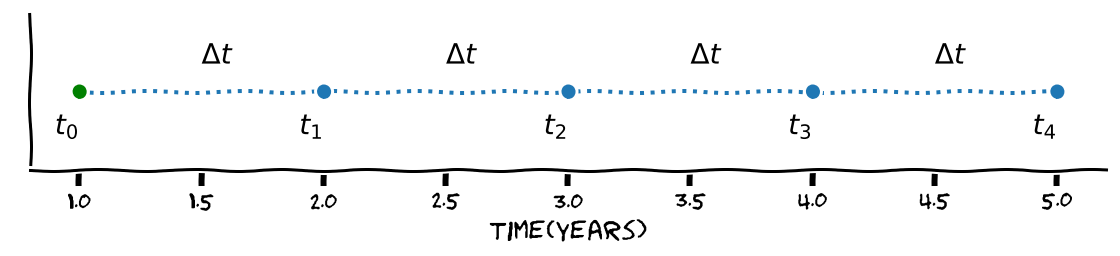

In [37]:
# @markdown *Execute this cell to visualize time steps*
dt  =1
t  =np.arange(1, 5+dt/2, dt) # Time from 1 to 5 years in 0.1 steps
with plt.xkcd():
    fig = plt.figure(figsize=(8, 2))
    plt.plot(t, 0*t, ':o')
    plt.plot(t[0] ,0*t[0],':go',label='Initial Condition')
    plt.text(t[0]-0.1, 0*t[0]-0.03, r'$t_0$')
    plt.text(t[1]-0.1, 0*t[0]-0.03, r'$t_1$')
    plt.text(t[2]-0.1, 0*t[0]-0.03, r'$t_2$')
    plt.text(t[3]-0.1, 0*t[0]-0.03, r'$t_3$')
    plt.text(t[4]-0.1, 0*t[0]-0.03,r'$t_4$')
    plt.text(t[0]+0.5, 0*t[0]+0.02, r'$\Delta t$')
    plt.text(t[1]+0.5, 0*t[0]+0.02, r'$\Delta t$')
    plt.text(t[2]+0.5, 0*t[0]+0.02, r'$\Delta t$')
    plt.text(t[3]+0.5, 0*t[0]+0.02, r'$\Delta t$')
    plt.yticks([])#plt.ylabel('Population (millions)')
    plt.xlabel('time(years)')
    plt.show()

### Coding Exercise 1.3: Step, step, step
Given the population differential equation:
\begin{align*}
\\
\frac{d}{dt}\,p(t) &= 0.3 p(t),\\
\end{align*}
and the initial condition:
\begin{align*}
\\
p(t_0=1)&=e^{0.3},
\end{align*}


code the difference equation:

\begin{align*}
\color{red}{p[k+1]}&=\color{green}{p[k]}+\color{blue}{\Delta t} (\color{blue}{0.3} \color{green}{p[k]}),\\
\color{green}{p[0]}&=e^{0.3},\quad \text{Initial Condition,}\\
&\text{for } k=0,1,\cdots 4,\\
\end{align*}

to estimate the population on the interval $[1,5]$ with a time-step $\Delta t=1$, denoted by `dt` in code.

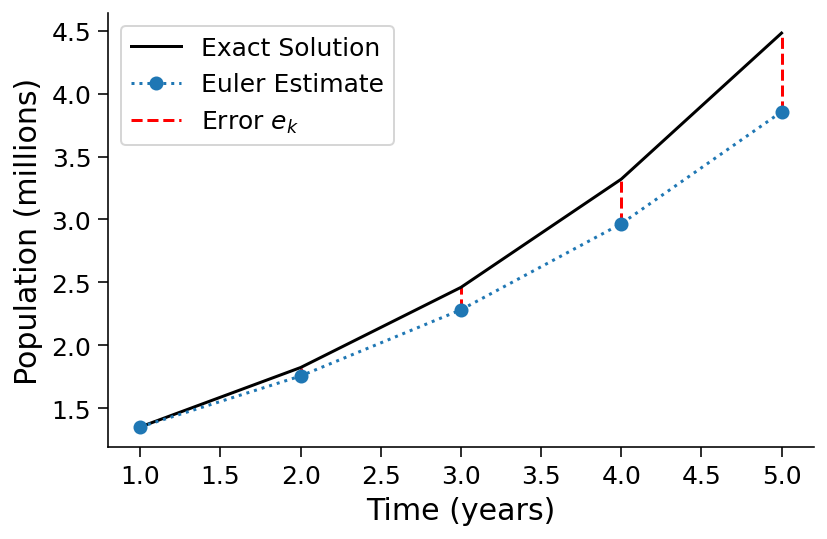

In [40]:
# Time step
dt = 1

# Make time range from 1 to 5 years with step size dt
t = np.arange(1, 5+dt/2, dt)

# Get number of steps
n = len(t)

# Initialize p array
p = np.zeros(n)
p[0] = np.exp(0.3*t[0]) # initial condition

# Loop over steps
for k in range(n-1):

  ########################################################################
  ## TODO for students
  ## Complete line of code and remove
  # raise NotImplementedError("Student exercise: calculate the population step for each time point")
  ########################################################################

  # Calculate the population step
  p[k+1] = p[k] + dt * 0.3 * p[k]

# Visualize
visualize_population_approx(t, p)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W0D4_Calculus/solutions/W0D4_Tutorial3_Solution_dffaca6b.py)

*Example output:*

<img alt='Solution hint' align='left' width=832.0 height=544.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W0D4_Calculus/static/W0D4_Tutorial3_Solution_dffaca6b_0.png>



The error is smaller for 4 time-steps than taking one large time step from 1 to 5 but do note that the error is increasing for each step. This is known as __global error__ so the futher in time you want to predict, the larger the error.
You can read the theorems [here.](https://colab.research.google.com/github/john-s-butler-dit/Numerical-Analysis-Python/blob/master/Chapter%2001%20-%20Euler%20Methods/102_Euler_method_with_Theorems_nonlinear_Growth_function.ipynb) 

---
# Section 2: Euler method for the leaky integrate and fire


*Estimated timing to here from start of tutorial: 26 min*

In [15]:
# @title Video 3: Leaky integrate and fire
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1k5411T7by", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="T85OcgY7xjo", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

<details>
<summary> <font color='blue'>Click here for text recap of video </font></summary>

The Leaky Integrate and Fire (LIF) differential equation is:

\begin{align}
\frac{dV}{dt} = \frac{-(V-E_L) + R_mI(t)}{\tau_m}\,
\end{align}

where $\tau_m$ is the time constant, $V$ is the membrane potential, $E_L$ is the resting potential, $R_m$ is leak resistance and $I(t)$ is the external input current. 

The solution of the LIF can be estimated by applying the Euler method to give the difference equation:

\begin{align}
\frac{\color{red}{V[k+1]}-\color{green}{V[k]}}{\color{blue}{\Delta t}}=\big(\frac{-(\color{green}{V[k]}-\color{blue}{E_L}) + \color{blue}{R_m}I[k]}{\color{blue}{\tau_m}}\big),\\
\end{align}
where $V[k]$ is the estimate of the membrane potential at time point $t[k]$.
Re-arranging the equation such that all the known terms are on the right gives:

\begin{align}
\color{red}{V[k+1]}=\color{green}{V[k]}+\color{blue}{\Delta t}\big(\frac{-(\color{green}{V[k]}-\color{blue}{E_L}) + \color{blue}{R_m}I[k]}{\color{blue}{\tau_m}}\big),\\
\text{for } k=0\cdots n-1,
\end{align}

where $\color{red}{V[k+1]}$ is the unknown membrane potential at $t[k+1]$, $\color{green}{V[k]} $ is known membrane potential, $\color{blue}{E_L}$, $\color{blue}{R_m}$ and $\color{blue}{\tau_m}$ are known parameters, $\color{blue}{\Delta t}$ is a chosen time-step and  $I(t_k)$ is a function for an external input current.

## Coding Exercise 2: LIF and Euler
Code the difference equation for the LIF:

\begin{align}
\color{red}{V[k+1]}=\color{green}{V[k]}+\color{blue}{\Delta t}\big(\frac{-(\color{green}{V[k]}-\color{blue}{E_L}) + \color{blue}{R_m}I[k]}{\color{blue}{\tau_m}}\big),\\
\text{for } k=0\cdots n-1,
\end{align}

with the given parameters set as:
* `V_reset = -75,`
* `E_L = -75,`
* `tau_m = 10,`
* `R_m = 10.`

We will then visualize the result.
The figure has three panels:
* the top panel is the sinusoidal input, $I$, 
* the middle panel is the estimate membrane potential $V_k$. To illustrate a spike, $V_k$ is set to $0$ and then reset, 
* the bottom panel is the raster plot with each dot indicating a spike.




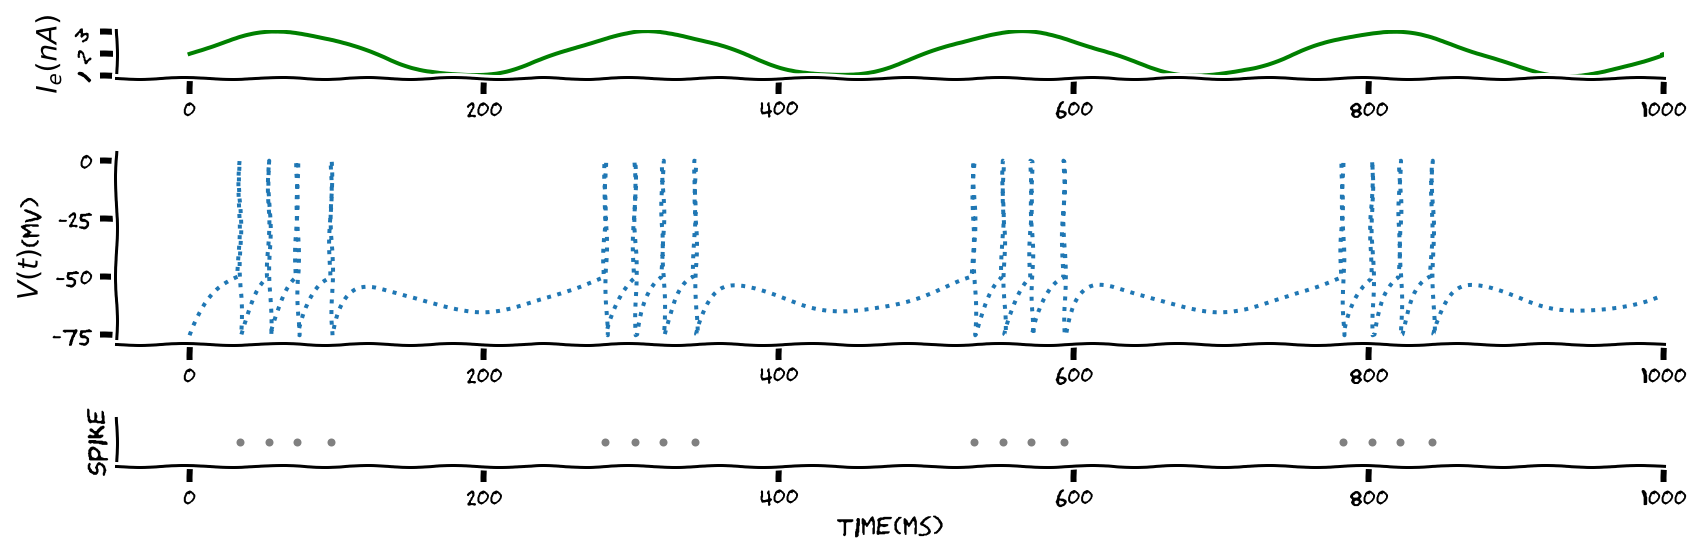

In [42]:
def Euler_Integrate_and_Fire(I, time, dt):
  """
  Args:
    I: Input
    time: time
    dt: time-step
  Returns:
    Spike: Spike count
    Spike_time: Spike times
    V: membrane potential esitmated by the Euler method
  """

  Spike = 0
  tau_m = 10
  R_m = 10
  t_isi = 0
  V_reset = E_L = -75
  n = len(time)
  V = V_reset * np.ones(n)
  V_th = -50
  Spike_time = []

  for k in range(n-1):
    #######################################################################
    ## TODO for students: calculate the estimate solution of V at t[i+1]
    ## Complete line of codes for dV and remove
    ## Run the code in Section 5.1 or 5.2 to see the output!
    # raise NotImplementedError("Student exercise: calculate the estimate solution of V at t[i+1]")
    ########################################################################

    dV = (-(V[k] - E_L) + R_m * I[k]) / tau_m
    V[k+1] = V[k] + dt*dV

    # Discontinuity for Spike
    if V[k] > V_th:
      V[k] = 0
      V[k+1] = V_reset
      t_isi = time[k]
      Spike = Spike + 1
      Spike_time = np.append(Spike_time, time[k])

  return Spike, Spike_time, V

# Set up time step and current
dt = 1
t = np.arange(0, 1000, dt)
I = np.sin(4 * 2 * np.pi * t/1000) + 2

# Model integrate and fire neuron
Spike, Spike_time, V = Euler_Integrate_and_Fire(I, t, dt)

# Visualize
plot_IF(t, V,I,Spike_time)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W0D4_Calculus/solutions/W0D4_Tutorial3_Solution_874eaa29.py)

*Example output:*

<img alt='Solution hint' align='left' width=1696.0 height=555.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W0D4_Calculus/static/W0D4_Tutorial3_Solution_874eaa29_0.png>



As electrophysiologists normally listen to spikes when conducting experiments,  listen to the music of the LIF neuron below. Note: this does not work on all browsers so just move on if you can't hear the audio.

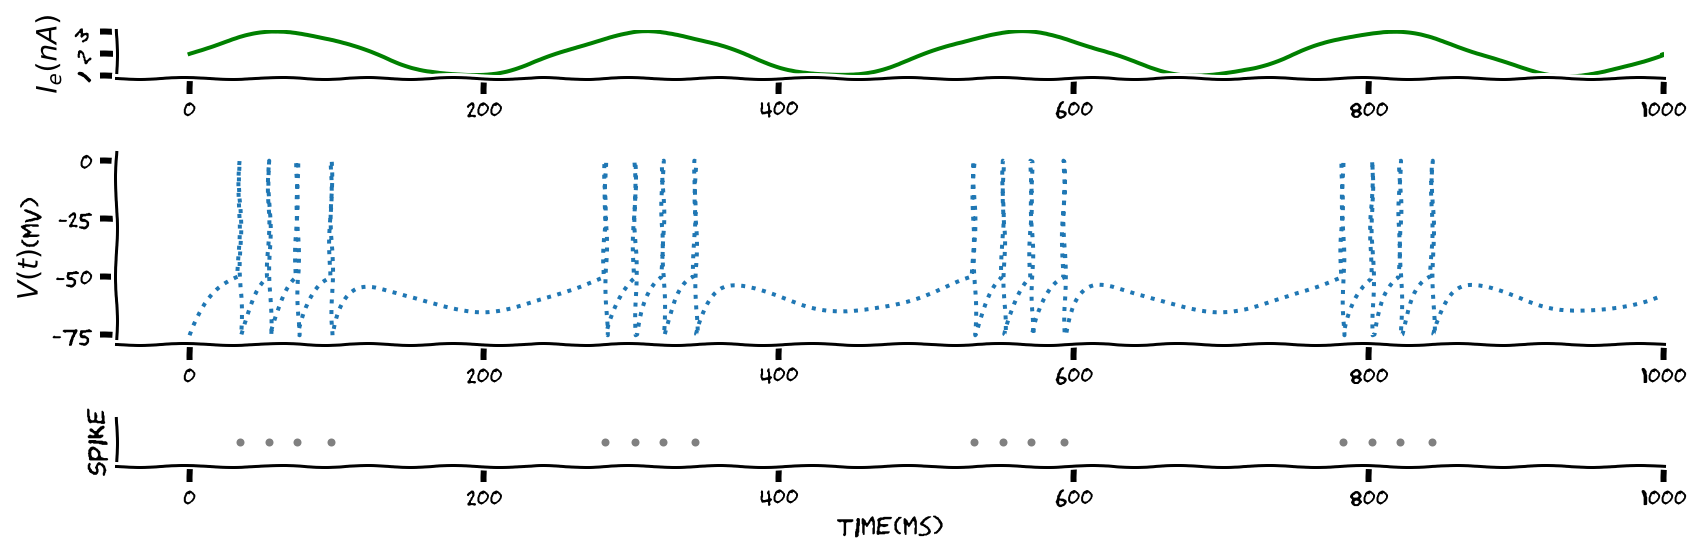

In [43]:
# @markdown *Execute this cell to visualize the LIF for sinusoidal input*

dt = 1
t = np.arange(0, 1000, dt)
I = np.sin(4 * 2 * np.pi * t/1000) + 2
Spike, Spike_time, V = Euler_Integrate_and_Fire(I, t, dt)

plot_IF(t, V,I,Spike_time)
plt.show()
ipd.Audio(V, rate=1000/dt)

---
# Section 3: Systems of differential equations


*Estimated timing to here from start of tutorial: 34 min*

In [17]:
# @title Video 4: Systems of differential equations
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1XV411s76a", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="A3Puozl9nEs", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

## Section 3.1: Using Euler to approximate a simple system

*Estimated timing to here from start of tutorial: 40 min*

<details>
<summary> <font color='blue'>Click here for text recap of relevant part of video </font></summary>

To get to grips with solving a system of differential equations using the Euler method, we will simplify the Wilson Cowan model, a set of equations that will be explored in more detail in the Dynamical Systems day.
Looking at systems of differential equations will also allow us to introduce the concept of a phase-plane plot which is a method of investigating how different processes interact.

In the previous section we looked at the LIF model for a single neuron. We now model a collection of neurons using a differential equation which describes the firing rate of a population of neurons. 
We will model the firing rate $r$ of two types of populations of neurons which interact, the excitation population firing rate $r_E$ and inhibition population firing rate $r_I$. These firing rates of neurons regulate each other by weighted connections $w$. The directed graph below illustrates this.

Our system of differential equations is a linear version of the Wilson Cowan model. Consider the equations, 

\begin{align}
\tau_E \frac{dr_E}{dt} &= w_{EE}r_E+w_{EI}r_I, \\
\tau_I \frac{dr_I}{dt} &= w_{IE}r_E+w_{II}r_I
\end{align}

$r_E(t)$ represents the average activation (or firing rate) of the excitatory population at time $t$, and $r_I(t)$ the activation (or firing rate) of the inhibitory population. The parameters $\tau_E$ and $\tau_I$ control the timescales of the dynamics of each population. Connection strengths are given by: $w_{EE}$ (E $\rightarrow$ E), $w_{EI}$ (I $\rightarrow$ E), $w_{IE}$ (E $\rightarrow$ I), and $w_{II}$ (I $\rightarrow$ I). The terms $w_{EI}$ and $w_{IE}$ represent connections from inhibitory to excitatory population and vice versa, respectively.

To start we will further simplify the linear system of equations by setting $w_{EE}$ and $w_{II}$ to zero, we now have the equations 

\begin{align}
\tau_E \frac{dr_E}{dt} &= w_{EI}r_I, \\
\tau_I \frac{dr_I}{dt} &= w_{IE}r_E, \qquad (1)
\end{align}

where $\tau_E=100$ and $\tau_I=120$, no internal connection $w_{EE}=w_{II}=0$, and $w_{EI}=-1$ and $w_{IE}=1$,
with the initial conditions

\begin{align}
r_E(0)=30, \\ 
r_I(0)=20.
\end{align}

The solution can be approximated using the Euler method such that we have the difference equations:

\begin{align*}
\frac{\color{red}{r_E[k+1]}-\color{green}{r_E[k]}}{\color{blue}{\Delta t}}&=\big(\frac{\color{blue}{w_{EI}}\color{green}{r_I[k]}}{\color{blue}{\tau_E}}\big),\\
\frac{\color{red}{r_I[k+1]}-\color{green}{r_I[k]}}{\color{blue}{\Delta t}}&=\big(\frac{\color{blue}{w_{IE}}\color{green}{r_E[k]}}{\color{blue}{\tau_I}}\big),\\
\end{align*}
where $r_E[k]$ and $r_I[k]$ are the numerical estimates of the firing rate of the excitation population $r_E(t[k])$ and inhibition population $r_I(t[k])$ and $\Delta t$ is the time-step.

Re-arranging the equation such that all the known terms are on the right gives:

\begin{align*}
\color{red}{r_E[k+1]}&=\color{green}{r_E[k]}+\color{blue}{\Delta t}\big(\frac{\color{blue}{w_{EI}}\color{green}{r_I[k]}}{\color{blue}{\tau_E}}\big),\\
\color{red}{r_I[k+1]}&=\color{green}{r_I[k]}+\color{blue}{\Delta t}\big(\frac{\color{blue}{w_{IE}}\color{green}{r_E[k]}}{\color{blue}{\tau_I}}\big),\\
&\text{ for  } k=0, \cdots , n-1,\\\\
r_E[0]&=30,\\
r_I[0]&=20.\\
\end{align*}

where $\color{red}{r_E[k+1]}$ and  $\color{red}{r_I[k+1]}$ are unknown, $\color{green}{r_E[k]} $ and  $\color{green}{r_I[k]} $ are known, $\color{blue}{w_{EI}}=-1$, $\color{blue}{w_{IE}}=1$ and $\color{blue}{\tau_E}=100ms$ and $\color{blue}{\tau_I}=120ms$  are known parameters and $\color{blue}{\Delta t}=0.01ms$ is a chosen time-step.
</details>





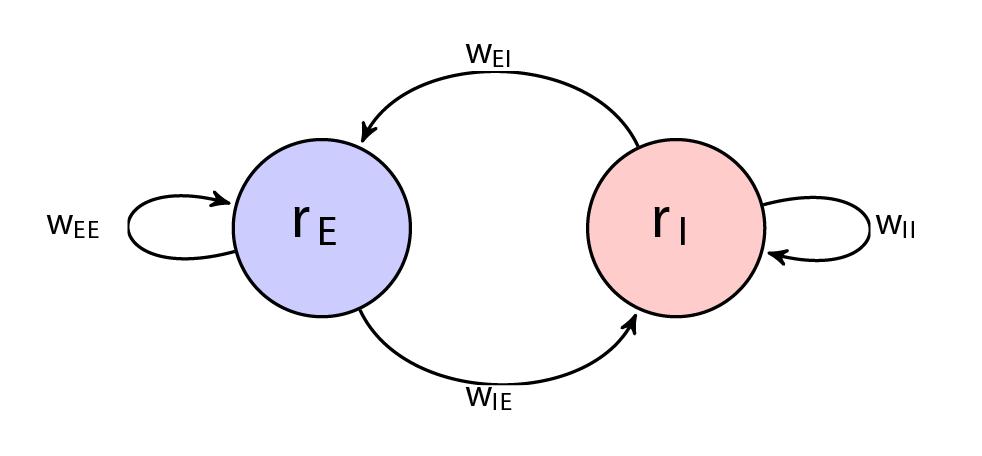

### Coding Exercise 3.1: Euler on a Simple System 

Our difference equations are: 

\begin{align*}
\color{red}{r_E[k+1]}&=\color{green}{r_E[k]}+\color{blue}{\Delta t}\big(\frac{\color{blue}{w_{EI}}\color{green}{r_I[k]}}{\color{blue}{\tau_E}}\big),\\
\color{red}{r_I[k+1]}&=\color{green}{r_I[k]}+\color{blue}{\Delta t}\big(\frac{\color{blue}{w_{IE}}\color{green}{r_E[k]}}{\color{blue}{\tau_I}}\big),\\
&\text{ for  } k=0, \cdots , n-1,\\\\
r_E[0]&=30,\\
r_I[0]&=20.\\
\end{align*}

where $\color{red}{r_E[k+1]}$ and  $\color{red}{r_I[k+1]}$ are unknown, $\color{green}{r_E[k]} $ and  $\color{green}{r_I[k]} $ are known, $\color{blue}{w_{EI}}=-1$, $\color{blue}{w_{IE}}=1$ and $\color{blue}{\tau_E}=100ms$ and $\color{blue}{\tau_I}=120ms$  are known parameters and $\color{blue}{\Delta t}=0.01ms$ is a chosen time-step.
__Code the difference equations to estimate $r_{E}$ and $r_{I}$.__

Note that the equations have to estimated in the same `for` loop as they depend on each other.

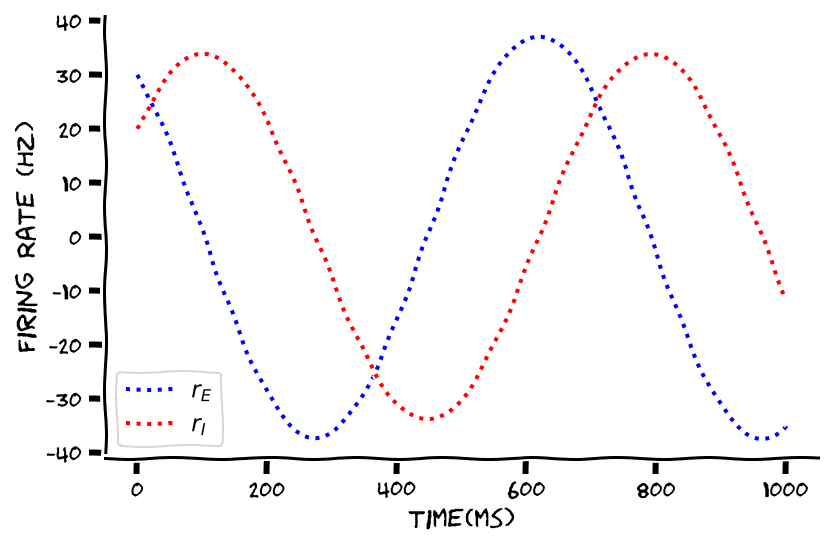

In [45]:
def Euler_Simple_Linear_System(t, dt):
  """
  Args:
    time: time
  dt  : time-step
  Returns:
    r_E : Excitation Firing Rate
    r_I : Inhibition Firing Rate

  """

  # Set up parameters
  tau_E = 100
  tau_I = 120
  n = len(t)
  r_I = np.zeros(n)
  r_I[0] = 20
  r_E = np.zeros(n)
  r_E[0] = 30

  #######################################################################
  ## TODO for students: calculate the estimate solutions of r_E and r_I at t[i+1]
  ## Complete line of codes for dr_E and dr_I and remove
  # raise NotImplementedError("Student exercise: calculate the estimate solutions of r_E and r_I at t[i+1]")
  ########################################################################

  # Loop over time steps
  for k in range(n-1):

    # Estimate r_e
    dr_E = -r_I[k] / tau_E
    r_E[k+1] = r_E[k] + dt*dr_E

    # Estimate r_i
    dr_I = r_E[k] / tau_I
    r_I[k+1] = r_I[k] + dt*dr_I

  return r_E, r_I

# Set up dt, t
dt = 0.1 # time-step
t = np.arange(0, 1000, dt)

# Run Euler method
r_E, r_I = Euler_Simple_Linear_System(t, dt)

# Visualize
plot_rErI(t, r_E, r_I)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W0D4_Calculus/solutions/W0D4_Tutorial3_Solution_77fad457.py)

*Example output:*

<img alt='Solution hint' align='left' width=832.0 height=544.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W0D4_Calculus/static/W0D4_Tutorial3_Solution_77fad457_0.png>



### Think! 3.1: Simple Euler solution to the Wilson Cowan model

1. Is the simulation biologically plausible?
2. What is the effect of combined excitation and inhibition?


[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W0D4_Calculus/solutions/W0D4_Tutorial3_Solution_5bbd8b66.py)



## Section 3.2: Phase Plane Plot and Nullcline


*Estimated timing to here from start of tutorial: 50 min*

<details>
<summary> <font color='blue'>Click here for text recap of relevant part of video </font></summary>

When there are two differential equations describing the interaction of two processes like excitation $r_{E}$ and inhibition $r_{I}$ that are  dependent on each other they can be plotted as a function of each other, which is known as a phase plane plot. The phase plane plot can give insight give insight into the state of the system but more about that later in Neuromatch Academy.

In the animated figure below, the panel of the left shows the excitation firing rate $r_E$ and the inhibition firing rate $r_I$ as a function of time. The panel on the right hand side is the phase plane plot which shows the inhibition firing rate $r_I$ as a function of excitation firing rate $r_E$.

An addition to the phase plane plot are the "nullcline". These lines plot when the rate of change $\frac{d}{dt}$ of the variables is equal to $0$. We saw a variation of this for a single differential equation in the differential equation tutorial.

As we have two differential equations we set $\frac{dr_E}{dt}=0$ and $\frac{dr_I}{dt}=0$ which gives the equations,

\begin{align}
0&= w_{EI}r_I, \\
0&= w_{IE}r_E,\\
\end{align}

these are a unique example as they are a vertical and horizontal line. Where the lines cross is the stable point which the $r_E(t)$ excitatory population and $r_I(t)$ the inhibitory population orbit around.


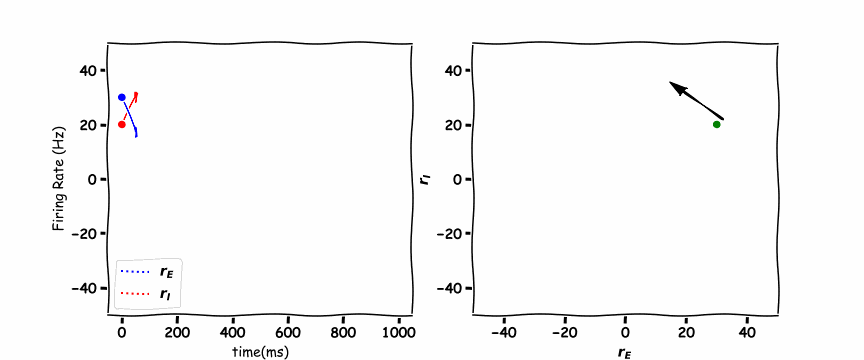


### Think! 6.1: Discuss the Plots

1. Which representation is more intuitive (and useful), the time plot or the phase plane plot?
2. Why do we only see one circle? 
3. What do the quadrants represent?


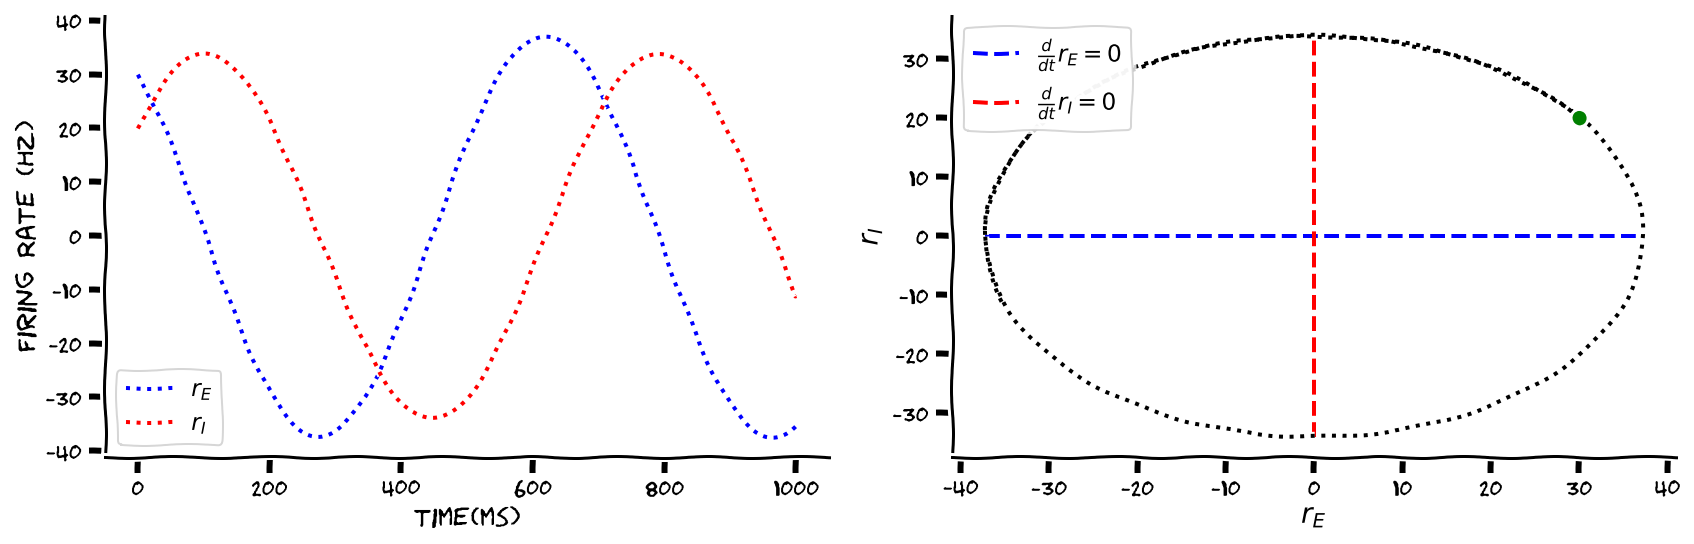

In [46]:
# @markdown Execute the code to plot the solution to the system
plot_rErI_Simple(t, r_E, r_I)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W0D4_Calculus/solutions/W0D4_Tutorial3_Solution_0f722767.py)



## Section 3.3: Adding internal connections

*Estimated timing to here from start of tutorial: 57 min*

Building up the equations in the previous section we re-introduce internal connections $w_{EE}$, $w_{II}$. The two coupled differential equations, each representing the dynamics of the excitatory or inhibitory population are now:

\begin{align}
\tau_E \frac{dr_E}{dt} &=w_{EE}r_E +w_{EI}r_I, \\
\tau_I \frac{dr_I}{dt} &=w_{IE}r_E +w_{II}r_I ,
\end{align}

where $\tau_E=100$ and $\tau_I=120$, $w_{EE}=1$ and $w_{II}=-1$, and $w_{EI}=-5$ and $w_{IE}=0.6$,
with the initial conditions

\begin{align}
r_E(0)=30, \\ 
r_I(0)=20.
\end{align}

The solutions can be approximated using the Euler method such that the equations become:

\begin{align*}
\frac{\color{red}{rE_{k+1}}-\color{green}{rE_k}}{\color{blue}{\Delta t}}&=\big(\frac{\color{blue}{w_{EE}}\color{green}{rE_k}+\color{blue}{w_{EI}}\color{green}{rI_k}}{\color{blue}{\tau_E}}\big),\\
\frac{\color{red}{rI_{k+1}}-\color{green}{rI_k}}{\color{blue}{\Delta t}}&=\big(\frac{\color{blue}{w_{II}}\color{green}{rI_k}+\color{blue}{w_{IE}}\color{green}{rE_k}}{\color{blue}{\tau_I}}\big),\\
\end{align*}
where $r_E[k]$ and $r_I[k]$ are the numerical estimates of the firing rate of the excitation population $r_E(t_k)$ and inhibition population $r_I(t_K)$ and $\Delta t$ is the time-step.

Re-arranging the equation such that all the known terms are on the right gives:

\begin{align*}
\color{red}{rE_{k+1}}&=\color{green}{rE_k}+\color{blue}{\Delta t}\big(\frac{\color{blue}{w_{EE}}\color{green}{rE_k}+\color{blue}{w_{EI}}\color{green}{rI_k}}{\color{blue}{\tau_E}}\big),\\
\color{red}{rI_{k+1}}&=\color{green}{rI_k}+\color{blue}{\Delta t}\big(\frac{\color{blue}{w_{II}}\color{green}{rI_k}+\color{blue}{w_{IE}}\color{green}{rE_k}}{\color{blue}{\tau_I}}\big),\\
&\text{ for } k=0, \cdots n-1,\\\\
rE_0&=30,\\
rI_0&=20.\\
\end{align*}
where $\color{red}{rE_{k+1}}$ and  $\color{red}{rI_{k+1}}$ are unknown, $\color{green}{rE_{k}} $ and  $\color{green}{rI_{k}} $ are known, $\color{blue}{w_{EI}}=-1$, $\color{blue}{w_{IE}}=1$, $\color{blue}{w_{EE}}=1$,  $\color{blue}{w_{II}}=-1$ and $\color{blue}{\tau_E}=100$ and $\color{blue}{\tau_I}=120$  are known parameters and $\color{blue}{\Delta t}=0.1$ is a chosen time-step.


### Think! 3.3: Oscillations


The code below implements and visualizes the linear Wilson-Cowan model.

1. What will happen to the oscillations if the time period is extended? 
2. How would you control or predict the oscillations? 

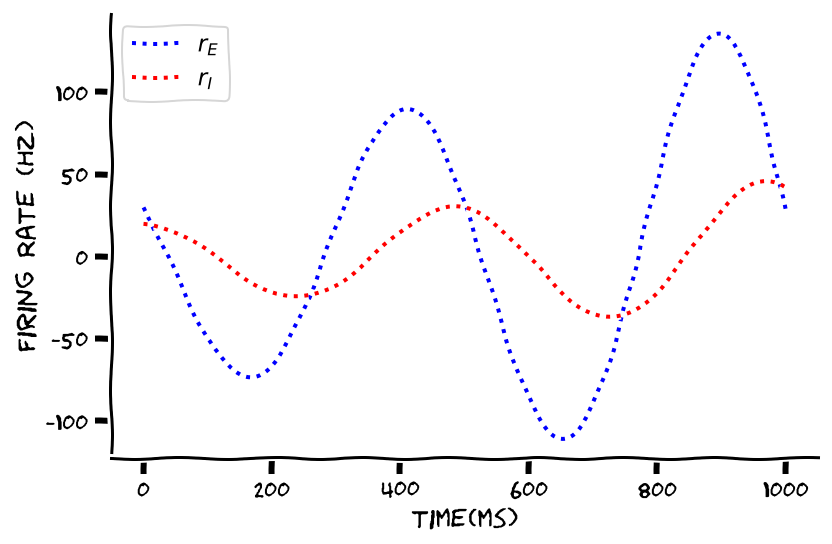

In [47]:
# @markdown *Execute this cell to visualize the Linear Willson-Cowan*

def Euler_Linear_System_Matrix(t, dt, w_EE=1):
  """
  Args:
    time: time
    dt: time-step
    w_EE: Excitation to excitation weight
  Returns:
    r_E: Excitation Firing Rate
    r_I: Inhibition Firing Rate
    N_Er: Nullclines for drE/dt=0
    N_Ir: Nullclines for drI/dt=0
  """

  tau_E = 100
  tau_I = 120
  n = len(t)
  r_I = 20*np.ones(n)
  r_E = 30*np.ones(n)
  w_EI = -5
  w_IE = 0.6
  w_II = -1

  for k in range(n-1):

    # Calculate the derivatives of the E and I populations
    drE = (w_EI*r_I[k] + w_EE*r_E[k]) / tau_E
    r_E[k+1] = r_E[k] + dt*drE

    drI = (w_II*r_I[k] + w_IE*r_E[k]) / tau_I
    r_I[k+1] = r_I[k] + dt*drI


  N_Er = -w_EE / w_EI*r_E
  N_Ir = -w_IE / w_II*r_E

  return r_E, r_I, N_Er, N_Ir


dt = 0.1 # time-step
t = np.arange(0, 1000, dt)
r_E, r_I, _, _ = Euler_Linear_System_Matrix(t, dt)
plot_rErI(t, r_E, r_I)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W0D4_Calculus/solutions/W0D4_Tutorial3_Solution_df2aee4c.py)



## Section 3.4 Phase Plane and Nullclines Part 2

*Estimated timing to here from start of tutorial: 62 min*

Like before, we have two differential equations so we can plot the results on a phase plane. We can also calculate the Nullclines when we set $\frac{dr_E}{dt}=0$ and $\frac{dr_I}{dt}=0$ which gives,
\begin{align}
0&= w_{EE}r_E+w_{EI}r_I, \\
0&= w_{IE}r_E+w_{II}r_I,
\end{align}
re-arranging as two lines
\begin{align}
r_I&= -\frac{w_{EE}}{w_{EI}}r_E, \\
r_I&= -\frac{w_{IE}}{w_{II}}r_E, 
\end{align}
which crosses at the stable point. 

The panel on the left shows excitation firing rate $r_E$ and inhibition firing rate  $r_I$ as a function of time. On the right side the phase plane plot shows inhibition firing rate $r_I$ as a function of excitation firing rate $r_E$ with the Nullclines for $\frac{dr_E}{dt}=0$ and $\frac{dr_I}{dt}=0.$

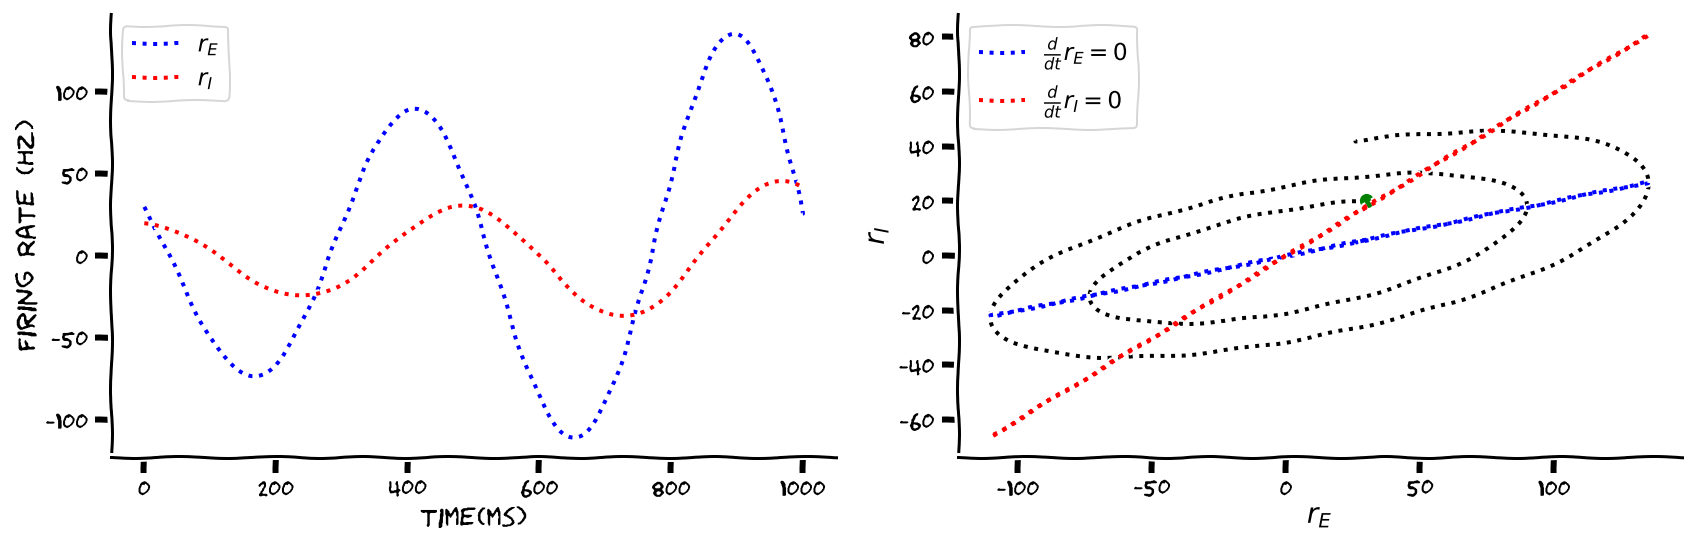

In [48]:
# @markdown *Run this cell to visualize the phase plane*
dt = 0.1 # time-step
t = np.arange(0, 1000, dt)
r_E, r_I, N_Er, N_Ir = Euler_Linear_System_Matrix(t, dt)
plot_rErI_Matrix(t, r_E, r_I, N_Er, N_Ir)

### Interactive Demo 3.4: A small change changes everything
We will illustrate that even changing one parameter in a system of differential equations can have a large impact on the solutions of the excitation firing rate $r_E$ and inhibition firing rate $r_I$.
Interact with the widget below to change the size of $w_{EE}$.

Take note of:
1. How the solution changes for positive and negative of $w_{EE}$. Pay close attention to the axis.

2. How would you maintain a stable oscillation.

In [49]:
# @markdown Make sure you execute this cell to enable the widget!
my_layout.width = '450px'
@widgets.interact(
    w_EE=widgets.FloatSlider(1, min=-1., max=2., step=.1,
                                layout=my_layout)
)

def Pop_widget(w_EE):
  dt = 0.1 # time-step
  t = np.arange(0,1000,dt)
  r_E, r_I, N_Er, N_Ir = Euler_Linear_System_Matrix(t, dt, w_EE)
  plot_rErI_Matrix(t, r_E, r_I, N_Er, N_Ir)
  plt.show()

interactive(children=(FloatSlider(value=1.0, description='w_EE', layout=Layout(width='450px'), max=2.0, min=-1…

---
# Summary

*Estimated timing of tutorial: 70 minutes*



In [30]:
# @title Video 5: Summary
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1wM4y1g78M", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="5UmGgboSc40", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

Using pretty much the formula for the slope of a line, the solution of differential equation can be estimated with reasonable accuracy. 
This will be much more relevant when dealing with more complicated (non-linear) differential equations where there is no known exact solution.

---
# Links to Neuromatch Days

The Euler method is used to estimate differential equations in a number of different Neuromatch days:
* The LIF model is discussed in more details in Model Types (Week 1 Day 1) and  Biological Neuron Models (Week 2 Day 3).
* Drift Diffusion model which is a differential equation for decision making is discussed in Linear Systems (Week 2 Day 2).
* Phase-plane plots are discussed in Linear Systems (Week 2 Day 2) and Dynamic Networks (Week 2 Day 4).
* The Wilson-Cowan model is discussed in Dynamic Networks (Week 2 Day 4).




---
# References 
1. Lotka, A. L, (1920)   Analytical note on certain rhythmic  relations inorganic  systems.Proceedings of the National Academy of Sciences,6(7):410–415,1920.

2. Brunel N, van Rossum MC. Lapicque's 1907 paper: from frogs to integrate-and-fire. Biol Cybern. 2007 Dec;97(5-6):337-9. doi: 10.1007/s00422-007-0190-0. Epub 2007 Oct 30. PMID: 17968583.



# Bibliography
1. Dayan, P., & Abbott, L. F. (2001). Theoretical neuroscience: computational and mathematical modeling of neural systems. Computational Neuroscience Series.
2. Strogatz, S. Nonlinear dynamics and chaos: with applications to physics, biology, chemistry, and engineering (studies in nonlinearity), Westview Press; 2 edition (29 July 2014)

## Supplemental Popular Reading List
1. Lindsay, G. (2021). Models of the Mind: How Physics, Engineering and Mathematics Have Shaped Our Understanding of the Brain. Bloomsbury Publishing.
2. Strogatz, S. (2004). Sync: The emerging science of spontaneous order. Penguin UK.

## Popular Podcast
1. Strogatz, S. (Host). (2020-), Joy of X  https://www.quantamagazine.org/tag/the-joy-of-x/ Quanta Magazine

---
# Bonus

---
## Bonus Section 1: The 4th Order Runge Kutta
Another popular numerical method to estimate the solution of differential equations of the general form: 
$$ \frac{d}{dt}y=f(t,y)$$
is the 4th Order Runge Kutta: 
$$k_1=f(t_k,y_k),$$
$$k_2=f(t_k+\frac{\Delta t}{2},y_k+\frac{\Delta t}{2}k_1),$$
$$k_3=f(t_k+\frac{\Delta t}{2},y_k+\frac{\Delta t}{2}k_2),$$
$$k_4=f(t_k+\Delta t,y_k+\Delta tk_3),$$
$$y_{k+1}=y_{k}+\frac{\Delta t}{6}(k_1+2k_2+2k_3+k_4),$$
for $k=0,1,\cdots,n-1$,
which is more accurate than the Euler method.

Given the population differential equation
\begin{align*}
\\
\frac{d}{dt}\,p(t) &= 0.3 p(t),\\
p(t_0=1)&=e^{0.3}\quad \text{Initial Condition},
\end{align*}
the 4th Runge Kutta difference equation is
\begin{align*}
k_1&=0.3\color{green}{p[k]},\\
k_2&=0.3(\color{green}{p[k]}+\frac{\Delta t}{2}k_1),\\
k_3&=0.3(\color{green}{p[k]}+\frac{\Delta t}{2}k_2),\\
k_4&=0.3(\color{green}{p[k]}+k_3),\\
\color{red}{p_{k[k]}}&=\color{green}{p[k]}+\frac{\color{blue}{\Delta t}}{6}( \color{green}{k_1+2k_2+2k_3+k_4})\\
&\text{for } k=0,1,\cdots 4
\end{align*}
to estimate the population for $\Delta t=0.5$.

The code is implemented below. Note how much more accurate the 4th Order Runge Kutta (yellow) is compared to the Euler Method (blue). The 4th order Runge Kutta is of order 4 which means that if you half the time-step $\Delta t$ the error decreases by a factor of $\Delta t^4$.


In [50]:
# @markdown *Execute this cell to show the difference between the Runge Kutta Method and the Euler Method*


def RK4(dt=0.5):
  t=np.arange(1, 5+dt/2, dt)
  t_fine=np.arange(1, 5+0.1/2, 0.1)
  n = len(t)
  p = np.ones(n)
  pRK4 = np.ones(n)
  p[0] = np.exp(0.3*t[0])
  pRK4[0] = np.exp(0.3*t[0])# Initial Condition

  with plt.xkcd():

    fig = plt.figure(figsize=(6, 4))
    plt.plot(t, np.exp(0.3*t), 'k', label='Exact Solution')

    for i in range(n-1):
      dp = dt*0.3*p[i]
      p[i+1] = p[i] + dp # Euler
      k1 = 0.3*(pRK4[i])
      k2 = 0.3*(pRK4[i] + dt/2*k1)
      k3 = 0.3*(pRK4[i] + dt/2*k2)
      k4 = 0.3*(pRK4[i] + dt*k3)
      pRK4[i+1] = pRK4[i] + dt/6 *(k1 + 2*k2 + 2*k3 + k4)

    plt.plot(t_fine, np.exp(0.3*t_fine), label='Exact')
    plt.plot(t, p,':ro', label='Euler Estimate')
    plt.plot(t, pRK4,':co',  label='4th Order Runge Kutta Estimate')

    plt.ylabel('Population (millions)')
    plt.legend()
    plt.xlabel('Time (years)')
    plt.show()

# @markdown Make sure you execute this cell to enable the widget!
my_layout.width = '450px'
@widgets.interact(
    dt=widgets.FloatSlider(0.5, min=.1, max=4., step=.1,
                                layout=my_layout)
)
def Pop_widget(dt):
    RK4(dt)

interactive(children=(FloatSlider(value=0.5, description='dt', layout=Layout(width='450px'), max=4.0, min=0.1)…

**Bonus Reference 1: A full course on numerical methods in Python**

For a full course on Numerical Methods for differential Equations you can look here https://github.com/john-s-butler-dit/Numerical-Analysis-Python

---
## Bonus  Section 2: Neural oscillations are a start toward understanding brain activity rather than the end

The differential equations we have discussed above are all to simulate neuronal processes, another way differential equations can be used is to motivate experimental findings.

A great deal of experimental and neurophysiological studies have investigated whether the brain oscillates and/or entrain to a stimulus.
An issue with these studies is that there is not a consistent  definition of what constitutes an oscillation. Right now it is a bit of I know one when I see one problem.


In an essay from May 2021 in PLOS Biology by Keith Dowling (a past Neuromatch TA) and M. Florencia Assaneo discussed a mathematical way of thinking about what should be expected experimentally  when studying  oscillations. In the essay they propose that instead of thinking about the brain we should look at this question from the mathematical side, to motivate what can be defined as an oscillation. 

To do this they used Stuart–Landau equations, which is a system of differential equations
\begin{align}
 \frac{dx}{dt} &=\lambda x-\omega y -\gamma (x^2+y^2)x+s\\
 \frac{dy}{dt} &=\lambda y+\omega x -\gamma (x^2+y^2)y 
\end{align}

where $s$ is input to the system, and $\lambda$, $\omega$ and $\gamma$ are parameters.

The Stuart–Landau equations are a well described system of non-linear differential equations that generate oscillations. For their purpose,  Dowling and  Assaneo used the equations to motivate what experimenters should expect when conducting experiments looking for oscillations. 
In their paper, using the Stuart–Landau equations, they outline 
* "What is an oscillator?"
* "What an oscillator is not"
* "Not all that oscillates is an oscillator"
* "Not all oscillators are alike."

The Euler form of the Stuart–Landau system of equations is:
\begin{align*}
\color{red}{x_{k+1}}&=\color{green}{x_k}+\color{blue}{\Delta t}\big(\lambda \color{green}{x_k}-\omega \color{green}{y_k} -\gamma (\color{green}{x_k}^2+\color{green}{y_k}^2)\color{green}{x_k}+s\big),\\
\color{red}{y_{k+1}}&=\color{green}{y_k}+\color{blue}{\Delta t}\big(\lambda \color{green}{y_k}+\omega \color{green}{x_k} -\gamma (\color{green}{x_k}^2+\color{green}{y_k}^2)\color{green}{y_k} \big),\\
&\text{ for } k=0, \cdots n-1,\\
x_0&=1,\\
y_0&=1,\\
\end{align*}
with $ \Delta t=0.1/1000$ ms.


In [ ]:
# @title Helper functions
def plot_Stuart_Landa(t, x, y, s):
  """
    Args:
      t  : time
      x  : x
      y  : y
      s : input
    Returns:
      figure with two panels
      top panel: Input as a function of time
      bottom panel: x
  """

  with plt.xkcd():
    fig = plt.figure(figsize=(14, 4))
    gs = gridspec.GridSpec(2, 2,  height_ratios=[1, 4], width_ratios=[4, 1])

    # PLOT OF INPUT
    plt.subplot(gs[0])
    plt.ylabel(r'$s$')
    plt.plot(t, s, 'g')
    #plt.ylim((2,4))

    # PLOT OF ACTIVITY
    plt.subplot(gs[2])
    plt.plot(t ,x)
    plt.ylabel(r'x')
    plt.xlabel(r't')
    plt.subplot(gs[3])
    plt.plot(x,y)
    plt.plot(x[0], y[0],'go')
    plt.xlabel(r'x')
    plt.ylabel(r'y')
    plt.show()


def Euler_Stuart_Landau(s,time,dt,lamba=0.1,gamma=1,k=25):
  """
  Args:
    I: Input
    time: time
    dt: time-step
  """

  n = len(time)
  omega = 4 * 2*np.pi
  x = np.zeros(n)
  y = np.zeros(n)
  x[0] = 1
  y[0] = 1

  for i in range(n-1):
    dx = lamba*x[i] - omega*y[i] - gamma*(x[i]*x[i] + y[i]*y[i])*x[i] + k*s[i]
    x[i+1] = x[i] + dt*dx
    dy = lamba*y[i] + omega*x[i] - gamma*(x[i]*x[i] + y[i]*y[i])*y[i]
    y[i+1] = y[i] + dt*dy

  return x, y

### Bonus 2.1: What is an Oscillator?
Doelling & Assaneo (2021), using the Stuart–Landau system, show different possible states of an oscillator by manipulating the $\lambda$ term in the equation. 
From the paper: "this qualitative change in behavior takes place at λ = 0: For λ < 0, the system decays to a stable equilibrium, while for λ > 0, it keeps oscillating."

This illustrates an oscillations does not have to maintain all the time, so experimentally we should not expect perfectly maintained oscillations. We see this all the time in $\alpha$ band oscillations in EEG the oscillations come and go.

#### Interactive Demo Bonus 2.1 
The plot below shows the estimated solution of the Stuart–Landau system with a base frequency $\omega$ set to $4\times 2\pi$, $\gamma=1$ and $k=25$ over 3 seconds. The input to the system $s(t)$ is plotted in the top panel, $x$ as a function of time in the the bottom panel and on the right the phase plane plot of $x$ and $y$. You can manipulate $\lambda$ to see how the oscillations change.

In [ ]:
# @markdown Make sure you execute this cell to enable the widget!
dt=0.1/1000
t=np.arange(0, 3, dt)

my_layout.width = '450px'
@widgets.interact(
    lamda=widgets.FloatSlider(1, min=-1., max=5., step=0.5,
                                layout=my_layout)
)

def Pop_widget(lamda):
    s=np.zeros(len(t))
    x,y=Euler_Stuart_Landau(s,t,dt,lamda)
    plot_Stuart_Landa(t, x, y, s)
    plt.show()

### Bonus 2.2 : Not all oscillators are alike

#### Interactive Demo Bonus 2: Stuart-Landau System 
The plot below shows estimated solution of the Stuart–Landau system with a base frequency of 4Hz by stetting $\omega$ to $4\times 2\pi$, $\lambda=1$, $\gamma=1$ and $k=50$ over 3 seconds the input to the system $s(t)=\sin(freq 2\pi t) $ in the top panel, $x$ as a function of time in the the bottom panel and on the right the phase plane plot of $x$ and $y$. 

You can manipulate the frequency $freq$ of the input to see how the oscillations change and for frequencies $freq$ further and further from the base frequency of 4Hz the oscillations breaks down.

This shoes that if you have an oscillating input into an oscillator with it does not have to respond by oscillating about could even breakdown. Hence the frequency of the input oscillation is important to the system. 
So if you flash something at 50Hz, for example, the visual system might not follow the signal but that does not mean the visual system is not an oscillator it might just be the wrong frequency.   

In [ ]:
# @markdown Make sure you execute this cell to enable the widget!
dt=0.1/1000
t=np.arange(0, 3, dt)

my_layout.width = '450px'
@widgets.interact(
    freq=widgets.FloatSlider(4, min=0.5, max=10., step=0.5,
                                layout=my_layout)
)

def Pop_widget(freq):
    s = np.sin(freq * 2*np.pi * t)

    x, y = Euler_Stuart_Landau(s, t, dt, lamba=1, gamma=.1, k=50)
    plot_Stuart_Landa(t, x, y, s)

**Bonus Reference 2**

[Doelling, K. B., & Assaneo, M. F. (2021). Neural oscillations are a start toward understanding brain activity rather than the end. PLoS biology, 19(5), e3001234.](https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.3001234)
